# LightGBM

In [112]:
# pip install xgboost

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split 
import lightgbm as lgb
import xgboost as xgb
from hyperopt import fmin, tpe, hp, partial, Trials, space_eval, STATUS_OK
from sklearn.preprocessing import LabelEncoder
import gc

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from functools import partial
from pprint import pprint
import numpy as np
from hyperopt.pyll import scope, stochastic
from plotly import express as px
from plotly import graph_objects as go
from plotly import offline as pyo
from sklearn.metrics import make_scorer, mean_squared_error, roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.utils import check_random_state

In [44]:
# label encoder
data = pd.read_csv('data_clear.csv', index_col=0)
for col in data.select_dtypes('object').columns:
    if col not in ['user']:
        lbl = LabelEncoder()
        data[col] = lbl.fit_transform(data[col].astype(str))


train = data[~data['label'].isnull()]
X = train.drop(columns=['user', 'label'], axis=1)
y = train.loc[:, 'label']
data.head()

,user,label,login_cnt_period1_x,province_x,city_x,sex_sex_x,sex_provider_x,sex_level_x,sex_verified_x,sex_regist_type_x,...,city_op2_cnt_mean,city_service1_cnt_mean,city_service1_amt_mean,city_agreement_total_mean,city_login_cnt_avg_mean,city_balance_avg_mean,city_balance2_mean,city_product1_amount_mean,city_product3_amount_mean,city_product7_cnt_mean
0,Train_00000,0.0,0.002782,17,45,0,0,1,0,1,...,0.023251,0.000873,0.000930,0.329782,0.024373,0.456977,0.394828,0.091954,0.086207,0.050836
1,Train_00001,1.0,0.006121,12,204,0,0,2,0,1,...,0.022878,0.000984,0.000758,0.316146,0.023442,0.435602,0.382383,0.064767,0.016839,0.060533
2,Train_00002,0.0,0.015597,5,331,0,0,2,0,7,...,0.023444,0.002224,0.001742,0.363854,0.020695,0.455987,0.341534,0.095847,0.102236,0.055430
3,Train_00005,0.0,0.011220,21,326,0,0,2,0,1,...,0.023927,0.003038,0.002174,0.337236,0.025890,0.474667,0.403333,0.066667,0.026667,0.056911
4,Train_00006,0.0,0.087933,13,106,0,0,2,0,7,...,0.024291,0.004410,0.006652,0.354192,0.020660,0.527459,0.434631,0.081967,0.024590,0.057943


In [19]:
seed=623

In [20]:
# prepare the test set for the final evaluation

# test_X = data[data['label'].isnull()]
# test_y = pd.read_csv('test_label_new.csv', index_col=0)
# test = pd.merge(test_X, test_y, on='user')
# test.shape

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=623)
train_data = lgb.Dataset(data=x_train,label=y_train)
test_data = lgb.Dataset(data=x_test,label=y_test)

In [22]:
df_train = train
df_test = data[data.label.isnull()].copy()

In [23]:
# # optimal parameters
# {'feature_fraction': 0.59, 
#  'learning_rate': 0.08748742858194956, 
#  'max_depth': 14, 
#  'num_leaves': 25, 
#  'reg_alpha': 10, 
#  'reg_lambda': 13, 
#  'sub_sample': 0.56}

In [24]:
ycol = 'label'
feature_names = list(filter(lambda x: x not in [ycol, 'user'], df_train.columns))

model = lgb.LGBMClassifier()

df_oof = df_train[['user', ycol]].copy()
df_oof['prob'] = 0
prediction = df_test[['user']]
prediction['prob'] = 0
df_importance_list = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for fold_id, (trn_idx, val_idx) in enumerate(kfold.split(df_train[feature_names], df_train[ycol])):
    X_train = df_train.iloc[trn_idx][feature_names]
    Y_train = df_train.iloc[trn_idx][ycol]

    X_val = df_train.iloc[val_idx][feature_names]
    Y_val = df_train.iloc[val_idx][ycol]

    print('\nFold_{} Training ================================\n'.format(
        fold_id + 1))

    lgb_model = model.fit(X_train,
                          Y_train,
                          eval_names=['train', 'valid'],
                          eval_set=[(X_train, Y_train), (X_val, Y_val)],
                          verbose=100,
                          early_stopping_rounds=50)

    pred_val = lgb_model.predict_proba(X_val, num_iteration=lgb_model.best_iteration_)[:, 1]
    df_oof.loc[val_idx, 'prob'] = pred_val

    pred_test = lgb_model.predict_proba(df_test[feature_names], num_iteration=lgb_model.best_iteration_)[:, 1]
    prediction['prob'] += pred_test / kfold.n_splits

    df_importance = pd.DataFrame({
        'column': feature_names,
        'importance': lgb_model.feature_importances_,
    })
    df_importance_list.append(df_importance)

    del lgb_model, pred_val, pred_test, X_train, Y_train, X_val, Y_val
    gc.collect()

<ipython-input-24-9786294b7f9d>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Fold_1 Training ================================

Training until validation scores don't improve for 50 rounds
[100]	train's binary_logloss: 0.381572	valid's binary_logloss: 0.488321
Did not meet early stopping. Best iteration is:
[100]	train's binary_logloss: 0.381572	valid's binary_logloss: 0.488321


<ipython-input-24-9786294b7f9d>:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Fold_2 Training ================================

Training until validation scores don't improve for 50 rounds
[100]	train's binary_logloss: 0.383142	valid's binary_logloss: 0.49076
Did not meet early stopping. Best iteration is:
[100]	train's binary_logloss: 0.383142	valid's binary_logloss: 0.49076


<ipython-input-24-9786294b7f9d>:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Fold_3 Training ================================

Training until validation scores don't improve for 50 rounds
[100]	train's binary_logloss: 0.382029	valid's binary_logloss: 0.491273
Did not meet early stopping. Best iteration is:
[100]	train's binary_logloss: 0.382029	valid's binary_logloss: 0.491273

Fold_4 Training ================================



<ipython-input-24-9786294b7f9d>:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training until validation scores don't improve for 50 rounds
[100]	train's binary_logloss: 0.383348	valid's binary_logloss: 0.482674
Did not meet early stopping. Best iteration is:
[100]	train's binary_logloss: 0.383348	valid's binary_logloss: 0.482674


<ipython-input-24-9786294b7f9d>:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Fold_5 Training ================================

Training until validation scores don't improve for 50 rounds
[100]	train's binary_logloss: 0.379639	valid's binary_logloss: 0.497461
Did not meet early stopping. Best iteration is:
[100]	train's binary_logloss: 0.379639	valid's binary_logloss: 0.497461


<ipython-input-24-9786294b7f9d>:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
pred_lgb = prediction
prediction.head()

,user,prob
38225,Train_08221,0.399940
38226,Train_23216,0.248271
38227,Train_29740,0.075234
38228,Train_11378,0.311373
38229,Train_09309,0.294714


In [26]:
test_y = pd.read_csv('test_label_new.csv', index_col=0)
test_y.head()

,user,label
3,Train_00003,0
4,Train_00004,0
7,Train_00007,0
15,Train_00015,1
19,Train_00019,0


In [27]:
test = pd.merge(test_y,prediction, on='user')
test.head()

,user,label,prob
0,Train_00003,0,0.130424
1,Train_00004,0,0.356456
2,Train_00007,0,0.007919
3,Train_00015,1,0.368814
4,Train_00019,0,0.329175


0.7334836909084267

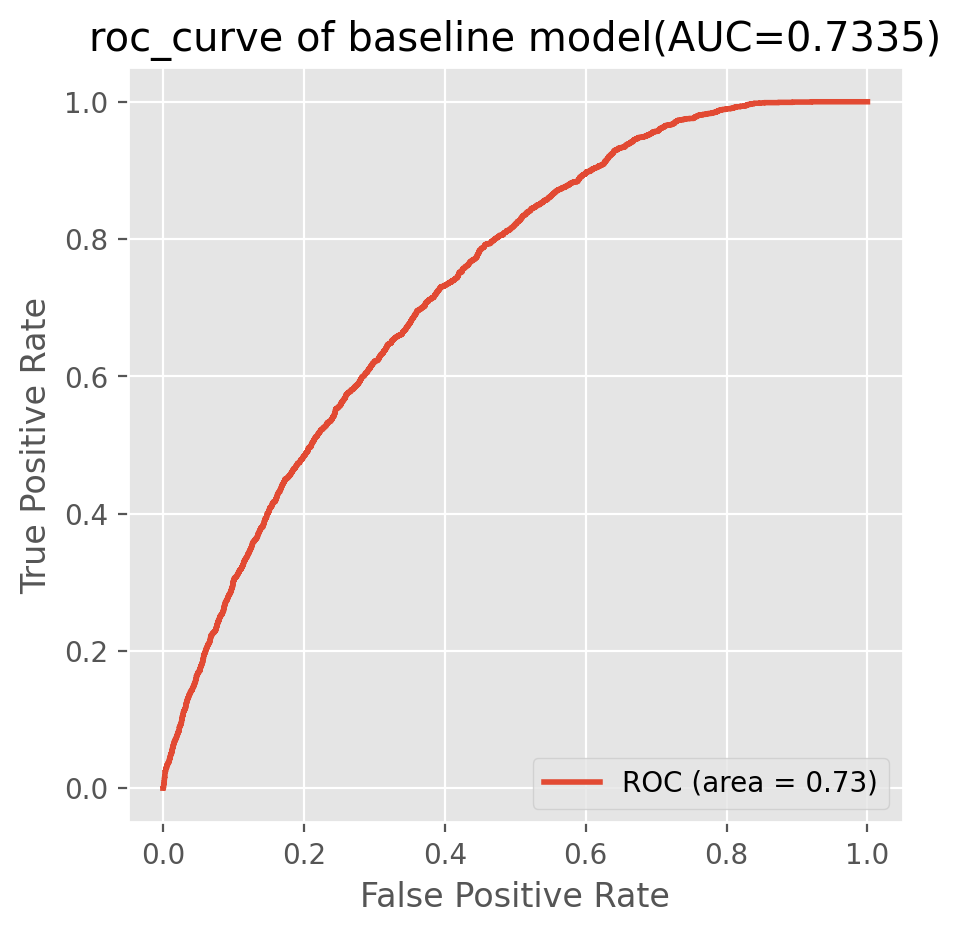

In [41]:
gbm_fpr,gbm_tpr,gbm_threasholds=roc_curve(test.iloc[:,1],test.iloc[:,2]) # 计算ROC的值,svm_threasholds为阈值

roc_auc = auc(gbm_fpr, gbm_tpr)

plt.figure(figsize=(5, 5))
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.title("roc_curve of %s(AUC=%.4f)" %('baseline model',roc_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(gbm_fpr,gbm_tpr, label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.legend(loc="lower right")
plt.savefig("baseline_roc.png")
roc_auc

In [29]:
df_importance = pd.concat(df_importance_list)
df_importance = df_importance.groupby(['column'])['importance'].agg('mean').sort_values(ascending=False).reset_index()

df_importance_top20 = df_importance.sort_values(by="importance", ascending=False).iloc[0:20,:]
df_importance_top100 = df_importance.sort_values(by="importance", ascending=False).iloc[0:100,:]
# print(df_importance_top100.iloc[:,0].tolist())

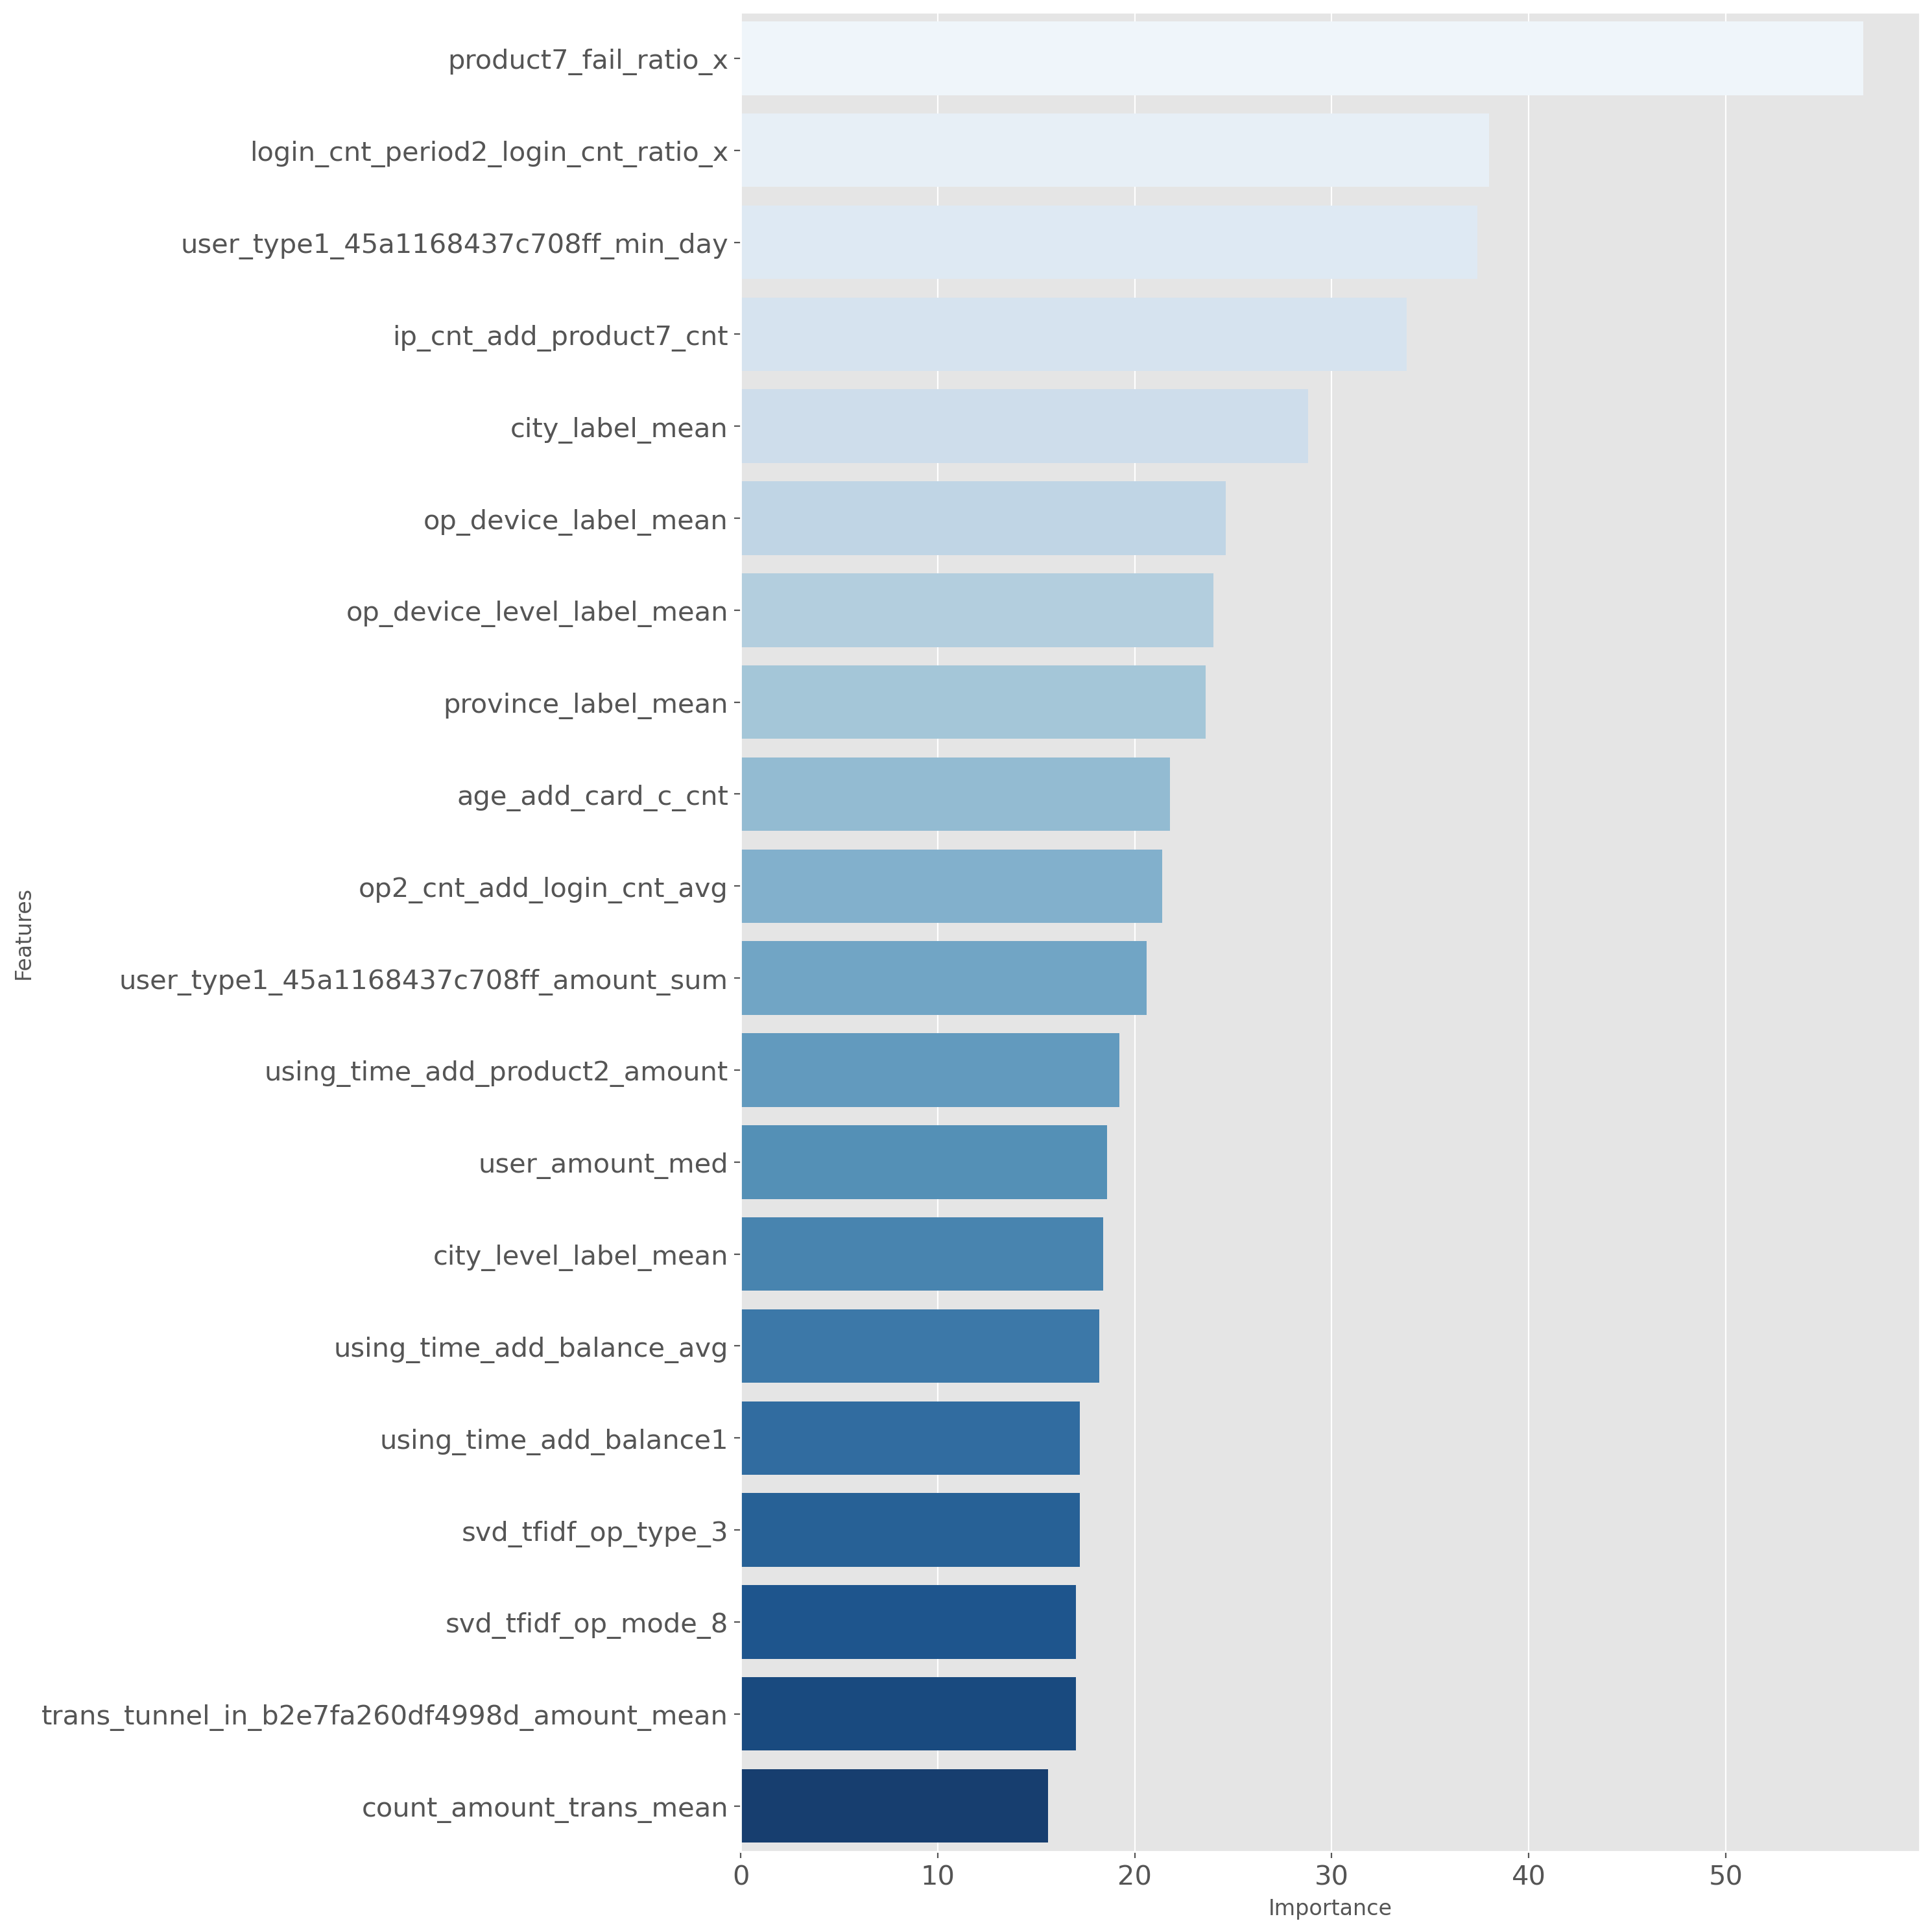

In [30]:
# feature importance visualization

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
# feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 15))
sns.barplot(x="importance", y="column", data=df_importance_top20, palette='Blues' ) 
# plt.title('LightGBM Features (avg over folds)')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.xlabel('Importance')
plt.ylabel('Features')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
# plt.show()
plt.savefig('lgbm_importances.png')

# XGBoost

In [31]:
%%time
ycol = 'label'
feature_names = list(
    filter(lambda x: x not in [ycol, 'user'], df_train.columns))

model = xgb.XGBClassifier( 
                           max_depth=6,
                           learning_rate=0.01,
                           n_estimators=10000,
                           subsample=0.8,
                           reg_alpha=10,
                           reg_lambda=12,
#                             tree_method='gpu_hist',
                           random_state=seed)

df_oof = df_train[['user', ycol]].copy()
df_oof['prob'] = 0
prediction = df_test[['user']]
prediction['prob'] = 0
df_importance_list = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for fold_id, (trn_idx, val_idx) in enumerate(
        kfold.split(df_train[feature_names], df_train[ycol])):
    X_train = df_train.iloc[trn_idx][feature_names]
    Y_train = df_train.iloc[trn_idx][ycol]

    X_val = df_train.iloc[val_idx][feature_names]
    Y_val = df_train.iloc[val_idx][ycol]

    print('\nFold_{} Training ================================\n'.format(
        fold_id + 1))

    lgb_model = model.fit(X_train,
                          Y_train,
                          eval_set=[(X_train, Y_train), (X_val, Y_val)],
                          verbose=100,
                          eval_metric='auc', 
                          early_stopping_rounds=50)

    pred_val = lgb_model.predict_proba(X_val,)[:, 1]
    df_oof.loc[val_idx, 'prob'] = pred_val

    pred_test = lgb_model.predict_proba(df_test[feature_names])[:, 1]
    prediction['prob'] += pred_test / kfold.n_splits

    df_importance = pd.DataFrame({
        'column': feature_names,
        'importance': lgb_model.feature_importances_,
    })
    df_importance_list.append(df_importance)

    del lgb_model, pred_val, pred_test, X_train, Y_train, X_val, Y_val
    gc.collect()

<timed exec>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Fold_1 Training ================================

[0]	validation_0-auc:0.68462	validation_1-auc:0.66837
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[100]	validation_0-auc:0.76043	validation_1-auc:0.71734
[200]	validation_0-auc:0.78194	validation_1-auc:0.72535
[300]	validation_0-auc:0.79716	validation_1-auc:0.73036
[400]	validation_0-auc:0.81009	validation_1-auc:0.73406
[500]	validation_0-auc:0.82209	validation_1-auc:0.73665
[600]	validation_0-auc:0.83483	validation_1-auc:0.73802
[700]	validation_0-auc:0.84747	validation_1-auc:0.73942
[800]	validation_0-auc:0.85959	validation_1-auc:0.73997
[900]	validation_0-auc:0.87071	validation_1-auc:0.74056
Stopping. Best iteration:
[894]	validation_0-auc:0.87000	validation_1-auc:0.74062



<timed exec>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Fold_2 Training ================================

[0]	validation_0-auc:0.68714	validation_1-auc:0.65709
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[100]	validation_0-auc:0.76261	validation_1-auc:0.71399
[200]	validation_0-auc:0.78387	validation_1-auc:0.72308
[300]	validation_0-auc:0.79882	validation_1-auc:0.72845
[400]	validation_0-auc:0.81162	validation_1-auc:0.73189
[500]	validation_0-auc:0.82386	validation_1-auc:0.73388
[600]	validation_0-auc:0.83589	validation_1-auc:0.73512
[700]	validation_0-auc:0.84766	validation_1-auc:0.73568
[800]	validation_0-auc:0.85902	validation_1-auc:0.73639
[900]	validation_0-auc:0.86943	validation_1-auc:0.73700
[1000]	validation_0-auc:0.87996	validation_1-auc:0.73764
[1100]	validation_0-auc:0.88946	validation_1-auc:0.73788
Stopping. Best iteration:
[1102]	validation_0-auc:0.88966	validation_1-auc:0.73791


Fold_3 Training ===================

In [32]:
pred_xgb = prediction

In [33]:
df_importance = pd.concat(df_importance_list)
df_importance = df_importance.groupby([
    'column'
])['importance'].agg('mean').sort_values(ascending=False).reset_index()
df_importance

,column,importance
0,user_amount_cnt,0.054871
1,agreement3_service3_x,0.033522
2,count_amount_trans_max,0.032645
3,agreement1_service3_x,0.019945
4,w2c_trans_type2_4_min,0.019757
...,...,...
740,sex_agreement3_y,0.000000
741,sex_agreement4_y,0.000000
742,sex_city_y,0.000000
743,sex_level_y,0.000000


In [34]:
auc = roc_auc_score(df_oof[ycol], df_oof['prob'])
print('auc:', auc)

auc: 0.7382839984113649


In [35]:
del auc

In [36]:
test_y = pd.read_csv('test_label_new.csv', index_col=0)
test = pd.merge(test_y,prediction, on='user')

In [37]:
test.head()

,user,label,prob
0,Train_00003,0,0.124882
1,Train_00004,0,0.315188
2,Train_00007,0,0.014052
3,Train_00015,1,0.315899
4,Train_00019,0,0.299570


0.7334836909084267

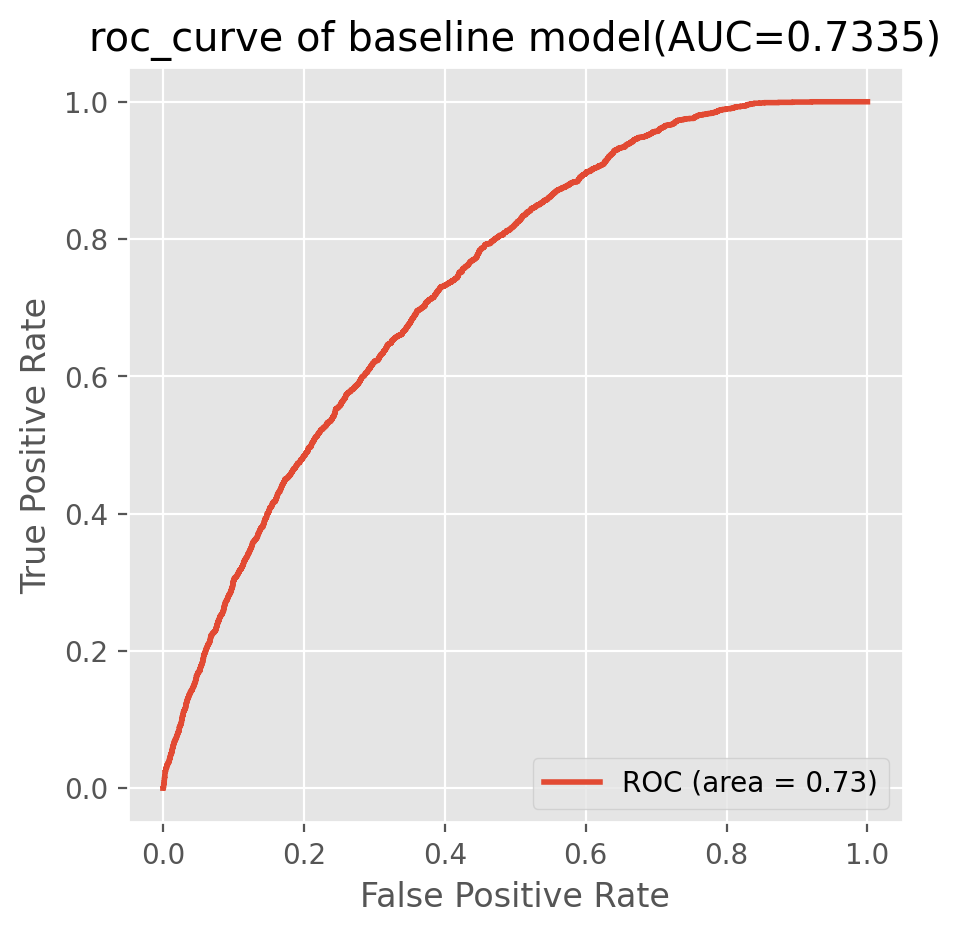

In [42]:
from sklearn.metrics import make_scorer, mean_squared_error, roc_auc_score, roc_curve, auc
gbm_fpr,gbm_tpr,gbm_threasholds=roc_curve(test.iloc[:,1],test.iloc[:,2]) # 计算ROC的值,svm_threasholds为阈值

roc_auc = auc(gbm_fpr, gbm_tpr)

plt.figure(figsize=(5, 5))
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.title("roc_curve of %s(AUC=%.4f)" %('baseline model',roc_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(gbm_fpr,gbm_tpr, label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.legend(loc="lower right")
plt.savefig("baseline_roc.png")
roc_auc

In [39]:
df_importance = pd.concat(df_importance_list)
df_importance = df_importance.groupby(['column'])['importance'].agg('mean').sort_values(ascending=False).reset_index()

df_importance_top20 = df_importance.sort_values(by="importance", ascending=False).iloc[0:20,:]
df_importance_top100 = df_importance.sort_values(by="importance", ascending=False).iloc[0:100,:]
# print(df_importance_top100.iloc[:,0].tolist())

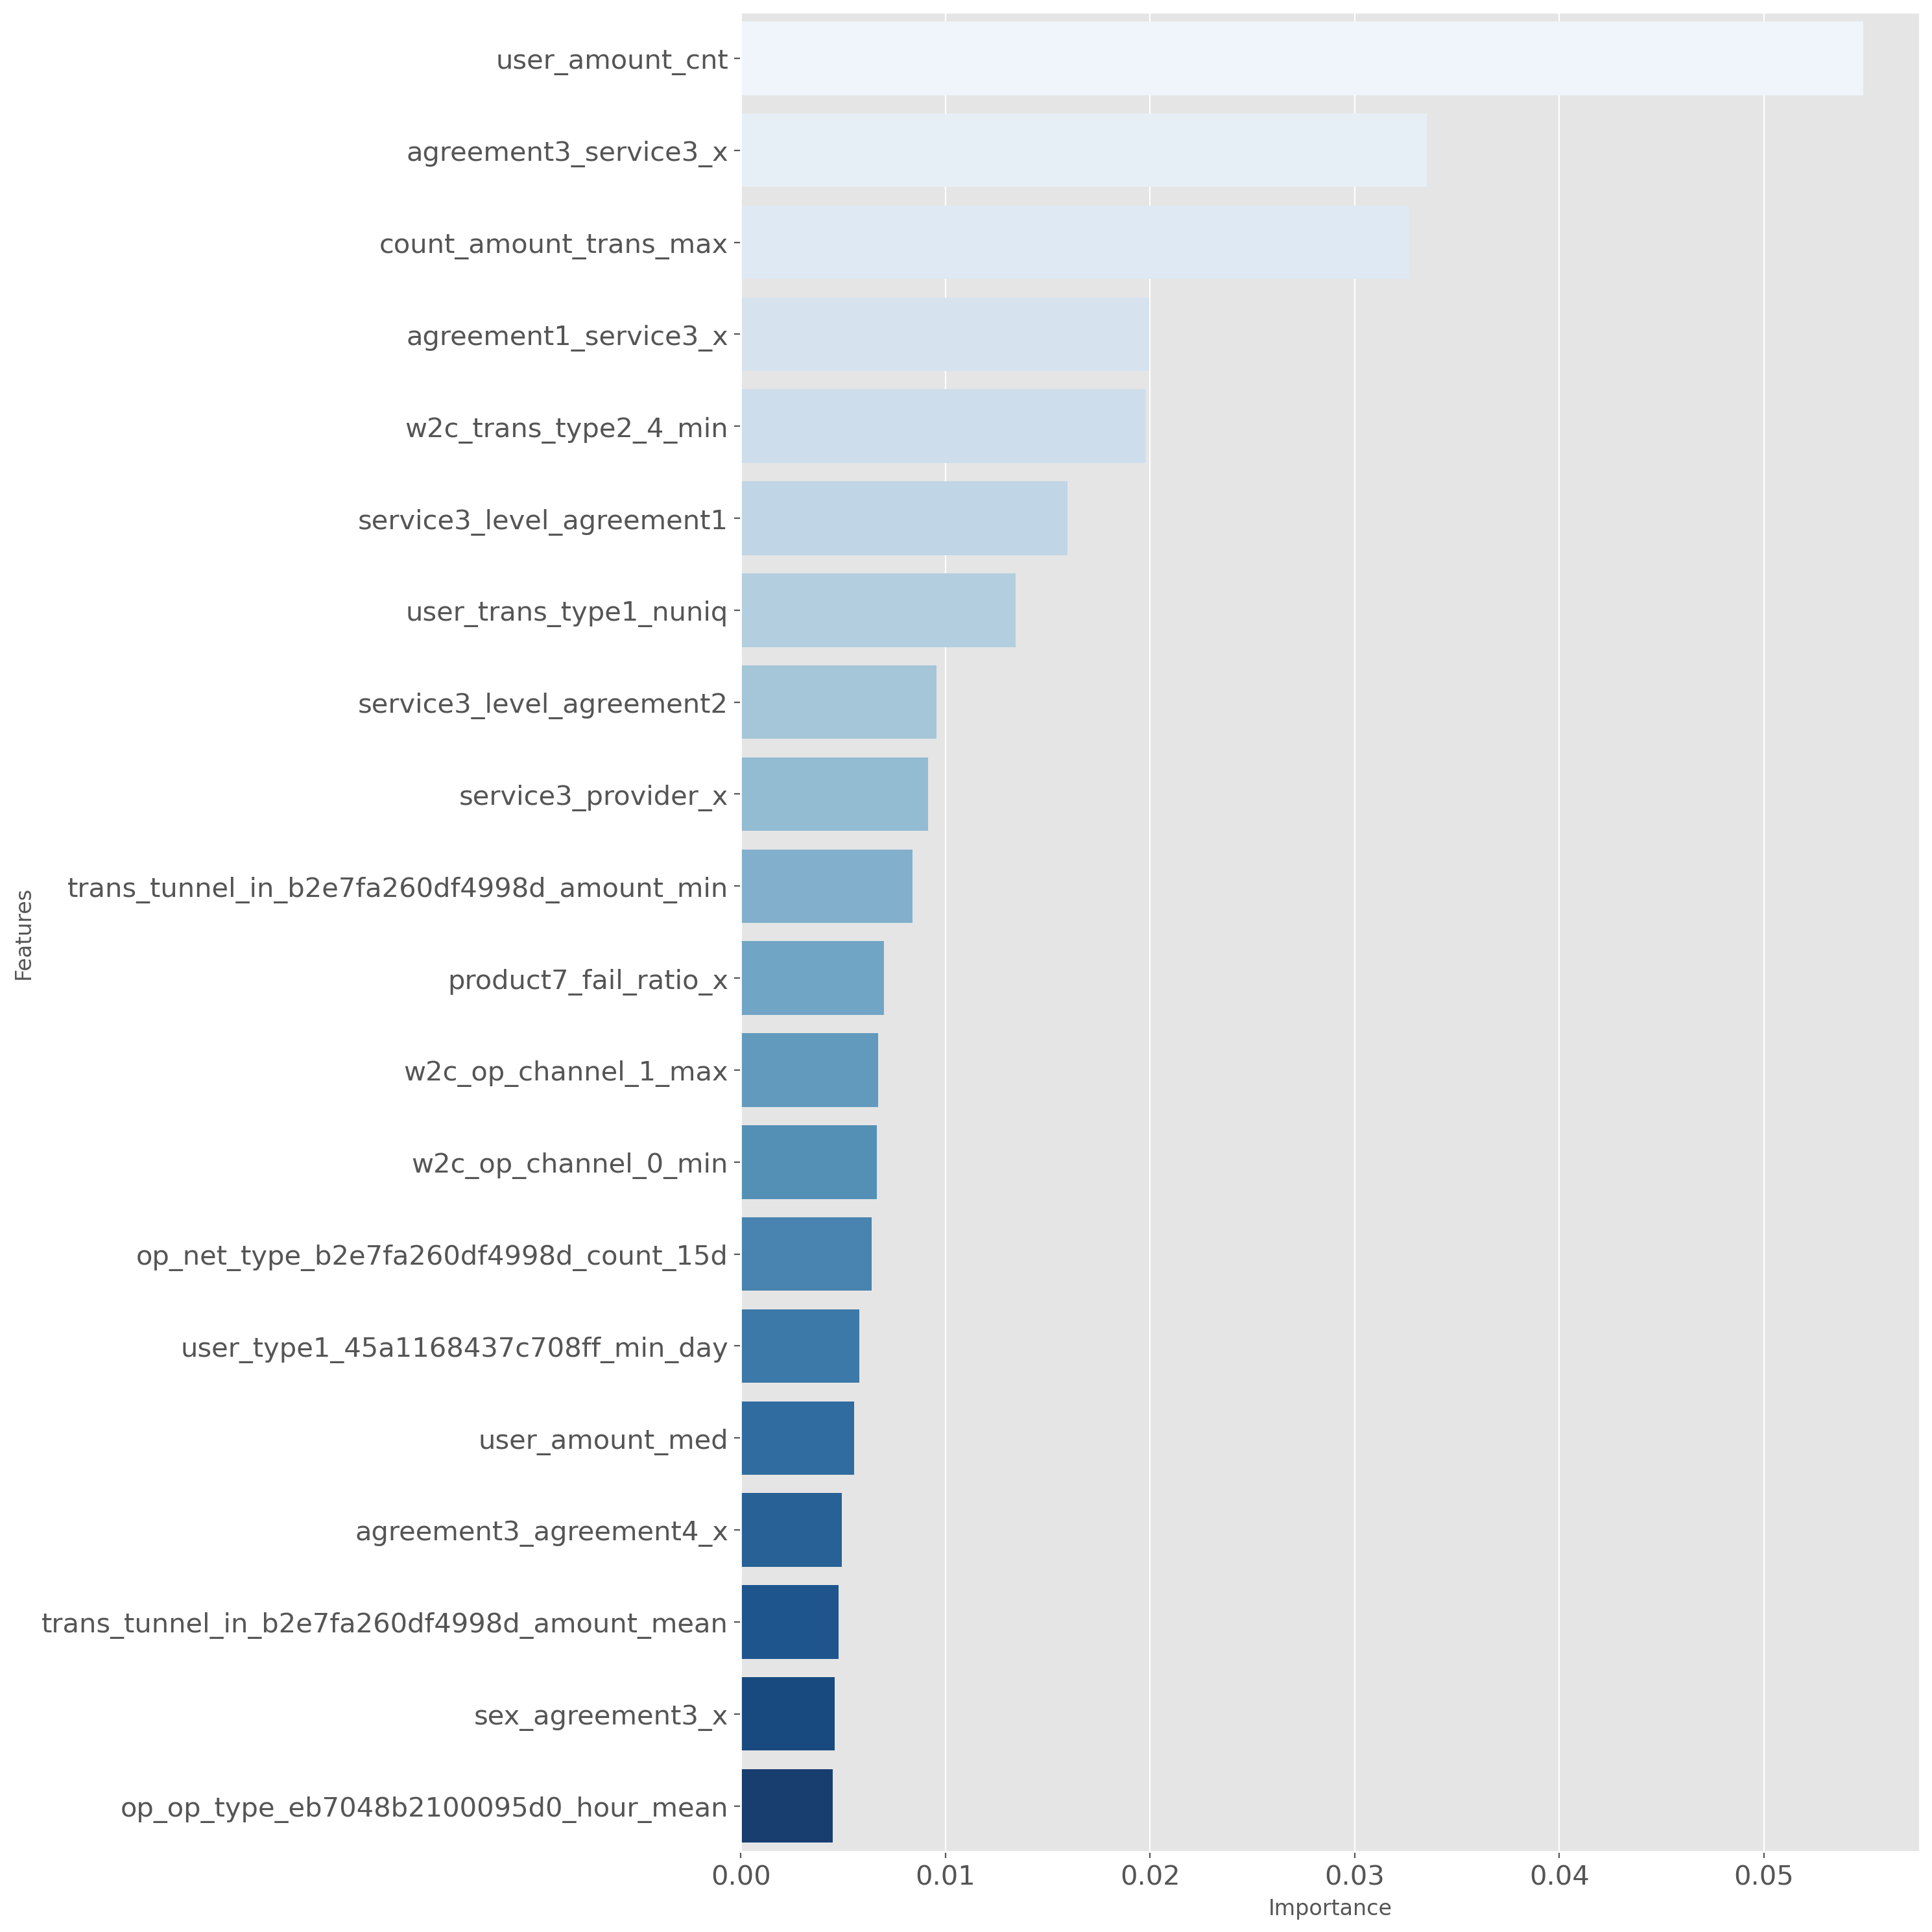

In [40]:
# feature importance visualization

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
# feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 15))
sns.barplot(x="importance", y="column", data=df_importance_top20, palette='Blues' ) 
# plt.title('LightGBM Features (avg over folds)')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.xlabel('Importance')
plt.ylabel('Features')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
# plt.show()
plt.savefig('xgb_importances.png')